In [28]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("cryptos.csv", index_col=0, parse_dates=True)
df.sort_index(inplace=True)
ticker = "BTCUSDT"
n_long = 1
stop_loss = 0.05
twenty_four_hours = 24

df_all = df.copy()

In [29]:
def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()

def run_backtest(lookback, trading_hours):
    price = df[ticker]
    momentum = price.pct_change(periods=lookback)
    momentum_clean = momentum.dropna()
    if len(momentum_clean) == 0:
        return 0.0, 0.0, pd.DataFrame()
    valid_start = momentum_clean.index[0]

    signals = pd.Series(0, index=momentum.index)

    lag = pd.Timedelta(hours=lookback)

    i = 0
    times = momentum.index
    n = len(times)

    while i < n:
        current_time = times[i]

        past_time = current_time - lag
        if past_time in momentum.index:
            if momentum[current_time] > momentum[past_time]:
                signal_value = 1
            elif momentum[current_time] < momentum[past_time]:
                signal_value = -1
            else:
                signal_value = 0
        else:
            signal_value = 0

        # Assign the signal for the next `trading_hours` periods starting at t+1
        for j in range(1, trading_hours + 1):
            if i + j < n:
                signals.iloc[i + j] = signal_value

        i += trading_hours  # jump ahead by trading_hours for next decision

    # Make sure to start from valid_start only
    signals = signals.loc[signals.index >= valid_start]

    returns = price.pct_change().loc[lambda x: x.index >= valid_start]
    portfolio_returns = returns * signals
    portfolio_returns = portfolio_returns.fillna(0)

    equity_values = np.ones(len(portfolio_returns))
    peak_values = np.ones(len(portfolio_returns))
    active_flags = np.ones(len(portfolio_returns), dtype=bool)

    for i in range(1, len(portfolio_returns)):
        if active_flags[i - 1]:
            equity_values[i] = equity_values[i - 1] * (1 + portfolio_returns.iloc[i])
            peak_values[i] = max(peak_values[i - 1], equity_values[i])
            if (equity_values[i] / peak_values[i] - 1) < -stop_loss:
                active_flags[i] = False
            else:
                active_flags[i] = True
        else:
            if portfolio_returns.iloc[i] != 0:
                active_flags[i] = True
                equity_values[i] = equity_values[i - 1] * (1 + portfolio_returns.iloc[i])
                peak_values[i] = equity_values[i]
            else:
                active_flags[i] = False
                equity_values[i] = equity_values[i - 1]
                peak_values[i] = peak_values[i - 1]

    cumulative_returns = pd.Series(equity_values, index=portfolio_returns.index)
    final_return = cumulative_returns.iloc[-1] - 1
    running_maximum = cumulative_returns.expanding().max()
    drawdown = ((cumulative_returns - running_maximum) / running_maximum).min()

    decision_df = pd.DataFrame({
        "equity": cumulative_returns,
        "position": signals.map({1: "long", -1: "short", 0: "none"}),
        "signal": signals,
        "price": price.loc[cumulative_returns.index],
        "momentum": momentum.loc[cumulative_returns.index]
    })

    # return final_return, drawdown, decision_df
    return final_return, drawdown

# Unit test

In [31]:
lookback = 4
resample_hours = 4
final_return, drawdown = run_backtest(lookback, resample_hours)

print(f"Lookback: {lookback}, Resample: {resample_hours}H | "
        f"Return: {final_return*100:.2f}%, Drawdown: {drawdown*100:.2f}%")

Lookback: 4, Resample: 4H | Return: -1.28%, Drawdown: -41.95%


# Test Loop

In [45]:
def run_grid_search():
    results = []
    for lookback in range(6, 13):
        for resample_hours in range(6, 13):
            final_return, drawdown = run_backtest(lookback, resample_hours)
            results.append({
                'lookback': lookback,
                'resample_hours': resample_hours,
                'final_return': final_return,
                'max_drawdown': drawdown
            })
            #print(f"Lookback: {lookback}, n_top: {n_top}, Resample: {resample_hours}H | "
            #      f"Return: {final_return*100:.2f}%, Drawdown: {drawdown*100:.2f}%")
    results_df = pd.DataFrame(results).sort_values(by="final_return", ascending=False).reset_index(drop=True)
    return results_df

# Test weekly

In [46]:
train_period_days, test_period_days, start_timestamp, total, previous_iteration_return, final_return = 14, 14, 0, 1, 0, 0
stop = int(((len(df_all) - 1)/twenty_four_hours - train_period_days)/test_period_days) + 1
print("train: ", train_period_days, "\ttest: ", test_period_days)

for i in range(0, stop):
    train_start = twenty_four_hours * start_timestamp
    train_end = train_start + twenty_four_hours * train_period_days
    test_start = train_end
    test_end = test_start + twenty_four_hours * test_period_days

    df_train = df_all.iloc[train_start:train_end]
    df_test = df_all.iloc[test_start:test_end]

    df = df_train
    results_df = run_grid_search()

    lookback = results_df.loc[0, 'lookback']
    resample_hours = results_df.loc[0, 'resample_hours']

    df = df_test
    final_return, drawdown = run_backtest(lookback, resample_hours)

    if previous_iteration_return >= 0:
        total *= (1 + final_return)
    else:
        total *= (1 + final_return)

    print(f"Lookback: {lookback}, Resample: {resample_hours}H | "
          f"Return: {final_return*100:.2f}%, Drawdown: {drawdown*100:.2f}%, Total: {total*100:.2f}%")

    previous_iteration_return = final_return
    start_timestamp += test_period_days

train:  14 	test:  14
Lookback: 9, Resample: 12H | Return: 12.12%, Drawdown: -4.17%, Total: 112.12%
Lookback: 11, Resample: 7H | Return: -5.84%, Drawdown: -11.00%, Total: 105.57%
Lookback: 6, Resample: 9H | Return: -12.70%, Drawdown: -14.65%, Total: 92.17%
Lookback: 10, Resample: 9H | Return: 2.92%, Drawdown: -9.44%, Total: 94.86%
Lookback: 7, Resample: 11H | Return: 12.58%, Drawdown: -9.32%, Total: 106.79%
Lookback: 11, Resample: 12H | Return: -6.96%, Drawdown: -10.88%, Total: 99.36%
Lookback: 7, Resample: 9H | Return: 1.56%, Drawdown: -14.38%, Total: 100.91%
Lookback: 11, Resample: 6H | Return: 1.27%, Drawdown: -12.94%, Total: 102.19%
Lookback: 7, Resample: 10H | Return: 3.72%, Drawdown: -6.83%, Total: 106.00%
Lookback: 12, Resample: 10H | Return: -2.44%, Drawdown: -7.45%, Total: 103.41%
Lookback: 6, Resample: 7H | Return: -3.79%, Drawdown: -9.08%, Total: 99.49%
Lookback: 6, Resample: 10H | Return: 5.77%, Drawdown: -4.35%, Total: 105.24%
Lookback: 7, Resample: 8H | Return: 6.64%, Dra

KeyboardInterrupt: 

In [32]:
train_period_days = 30
test_period_days = 30
start_timestamp, total, previous_iteration_return, final_return = 0, 1, 0, 0

for i in range(0, 10):
    train_start = twenty_four_hours * start_timestamp
    train_end = train_start + twenty_four_hours * train_period_days
    test_start = train_end
    test_end = test_start + twenty_four_hours * test_period_days

    print(train_start/24)
    print(train_end/24)
    print(test_start/24)
    print(test_end/24)
    print('________________________')

    start_timestamp += test_period_days


0.0
30.0
30.0
60.0
________________________
30.0
60.0
60.0
90.0
________________________
60.0
90.0
90.0
120.0
________________________
90.0
120.0
120.0
150.0
________________________
120.0
150.0
150.0
180.0
________________________
150.0
180.0
180.0
210.0
________________________
180.0
210.0
210.0
240.0
________________________
210.0
240.0
240.0
270.0
________________________
240.0
270.0
270.0
300.0
________________________
270.0
300.0
300.0
330.0
________________________


# Plot

In [22]:
df = df_all[125*twenty_four_hours:150*twenty_four_hours]

lookback = 4
n_top = 1
resample_hours = 8
final_return, drawdown, cumret = run_backtest(lookback, n_top, resample_hours)

print(f"Lookback: {lookback}, n_top: {n_top}, Resample: {resample_hours}H | "
        f"Return: {final_return*100:.2f}%, Drawdown: {drawdown*100:.2f}%")

Lookback: 4, n_top: 1, Resample: 8H | Return: 20.67%, Drawdown: -11.11%


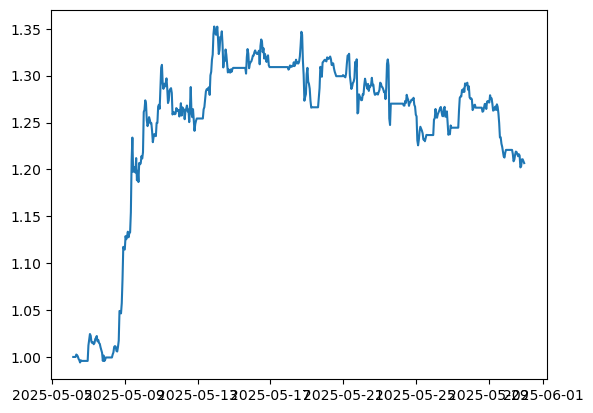

In [23]:
import matplotlib.pyplot as plt
plt.plot(cumret)